In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import string
from psycopg2 import connect
import re

In [2]:
df = pd.read_csv('sentence_training_set_1.csv', encoding="latin-1")

In [3]:
df.head()

,sentence,label
0,LocationSituated right in the city centre of B...,0.0
1,"Located in the charming area of Albuquerque, t...",0.0
2,Hotel The Ein Kerem is an elegant boutique ho...,1.0
3,This hotel is located on Via del Tritone in th...,0.0
4,"Surrounded by wonderful Cretan countryside, t...",0.0


In [4]:
df.label.value_counts()

1.0     2777
0.0     2454
11.0       1
Name: label, dtype: int64

In [5]:
df.isnull().sum()

sentence    0
label       2
dtype: int64

In [6]:
df.dropna(subset=['label'], inplace=True)
df = df[df.label != 11]
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
def print_plot(index):
    example = df[df.index == index][['sentence', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('label:', example[1])

In [8]:
print_plot(10)

 Take NY-27 West/Sunrise Highway to the belt Parkway West ramp on the left to Verrazano Bridge
label: 1.0


In [9]:
print_plot(100)

 All rooms are in good condition, and are traditionally furnished with burgundy features
label: 1.0


In [10]:
df['length'] = df['sentence'].apply(len)

Compare sentence length of the different labels.

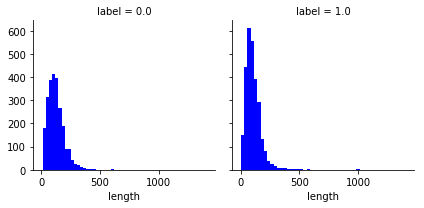

In [11]:
graph = sns.FacetGrid(data=df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue');

In [12]:
X = df['sentence']
y = df['label']
print(X.head())
print(y.head())

0    The air-conditioned apartments at Mc Queen hot...
1     From our restaurant, where we serve our gener...
2     Our hotel in Flagstaff, AZ, brings you true r...
3    All of the rooms are suites are well-equipped ...
4     Guests will find themselves in close proximit...
Name: sentence, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: label, dtype: float64


In [13]:
# Clean sentence
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
count_vect = CountVectorizer(analyzer=text_process, token_pattern=r'\w{1,}', ngram_range=(1, 3)).fit(X)
print(len(count_vect.vocabulary_))
r0 = X[0]
print(r0)
vocab0 = count_vect.transform([r0])
print(vocab0)

10819
The air-conditioned apartments at Mc Queen hotel are minimally decorated
  (0, 3531)	1
  (0, 4381)	1
  (0, 5855)	1
  (0, 5960)	1
  (0, 6980)	1
  (0, 7959)	1
  (0, 8602)	1


In [15]:
print(count_vect.get_feature_names()[5950])
print(count_vect.get_feature_names()[10216])

antiques
tax


In [16]:
count_vect

CountVectorizer(analyzer=<function text_process at 0x7fe2d0503510>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 3), preprocessor=None,
        stop_words=None, strip_accents=None, token_pattern='\\w{1,}',
        tokenizer=None, vocabulary=None)

In [17]:
X = count_vect.transform(X)
#Shape of the matrix:
print("Shape of the sparse matrix: ", X.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",X.nnz)

# DENSITY OF THE MATRIX
density = (X.nnz/(X.shape[0]*X.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (5231, 10819)
Non-Zero occurences:  61369
Density of the matrix =  0.10843692803867197


In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_train)
print("---Training Set Results---")
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_train, y_pred))
print("Score: ",round(accuracy_score(y_train,y_pred)*100,3))
print("Classification Report:")
print(classification_report(y_train, y_pred))

---Training Set Results---
Confusion Matrix for XGBoost Classifier:
[[1461  515]
 [ 107 2101]]
Score:  85.134
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.74      0.82      1976
         1.0       0.80      0.95      0.87      2208

   micro avg       0.85      0.85      0.85      4184
   macro avg       0.87      0.85      0.85      4184
weighted avg       0.86      0.85      0.85      4184



In [20]:
pred = xgb.predict(X_test)
print("---Test Set Results---")
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,pred))
print("Score: ",round(accuracy_score(y_test,pred)*100,3))
print("Classification Report:")
print(classification_report(y_test,pred))

---Test Set Results---
Confusion Matrix for XGBoost Classifier:
[[334 144]
 [ 33 536]]
Score:  83.095
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79       478
         1.0       0.79      0.94      0.86       569

   micro avg       0.83      0.83      0.83      1047
   macro avg       0.85      0.82      0.82      1047
weighted avg       0.84      0.83      0.83      1047



In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

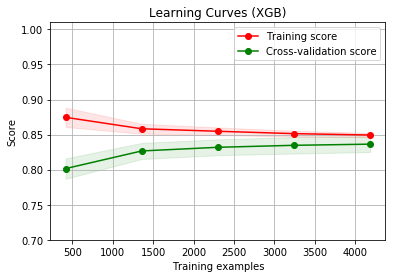

In [22]:
title = "Learning Curves (XGB)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = XGBClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4);

In [26]:
# lbl_enc = preprocessing.LabelEncoder()
# y = lbl_enc.fit_transform(df.label.values)
# X_train, X_test, y_train, y_test = train_test_split(df.sentence.values, y, random_state=42, test_size=0.2)
# target_names = lbl_enc.classes_

In [27]:
# countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
#             ngram_range=(1, 3), stop_words = 'english', binary=True)
# countvec.fit(list(X_train) + list(X_test))
# X_train_countvec =  countvec.transform(X_train) 
# X_test_countvec = countvec.transform(X_test)

In [28]:
# clf = XGBClassifier(n_jobs=-1)
# clf.fit(X_train_countvec.tocsc(), y_train)
# y_pred = clf.predict(X_test_countvec.tocsc())
# print("---Test Set Results---")
# print("Accuracy with Xgboost: {}".format(accuracy_score(y_test, y_pred)))
# print(classification_report(y_test, y_pred))

In [29]:
# for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
#     if y != y_hat:
#         print(f'sentence: {x} label: {y} label_pred: {y_hat}')

### Fetch hotels in New York

In [23]:
conn = connect(
    host='XXX',
    port='XXX',
    dbname='XXX',
    user='XXX',
    password='XXX')
conn.readonly = XXX
query = """
   XXX
"""
ny_hotels = pd.read_sql(query, con=conn)
conn.close()

In [24]:
ny_hotels.head()

,name,description
0,11 Howard,11 Howard is located at the crossroads of the ...
1,1 Hotel Brooklyn Bridge,Welcome to your Brooklyn Bridge waterfront ret...
2,1 Hotel Central Park,1 Hotel Central Park is a 5-star property loca...
3,36 Hudson Hotel,Ticket services and free Wi-Fi head the list o...
4,6 Columbus Central Park a Sixty Hotel,hotelinformation Overlooking Columbus Circle a...


In [25]:
ny_hotels = pd.concat([pd.Series(str(row['name']), str(row['description']).split('. '))              
                    for _, row in ny_hotels.iterrows()]).reset_index()
ny_hotels.columns = ['sentence', 'name']
ny_hotels['sentence'] = ny_hotels['sentence'].map(lambda x: re.sub(r'\W+', ' ', x))
print('We have ', len(ny_hotels), 'sentences in New York hotels')

We have  18719 sentences in New York hotels


In [26]:
a = 22
for i in range(a,a+7):
    print(ny_hotels.sentence[i])
    print()

Welcome to your Brooklyn Bridge waterfront retreat with expansive views of the East River and Manhattan skyline

The hotel is 100 non smoking

A 350 cleaning fee will be charged to any guest who violates the smoking policy

 Fee subject to change 150 incidental deposit will be charged to guests with either a major credit card or debit card

 Fee subject to change Unless notified prior to or at check in a one night penalty will apply to departures that occur earlier than the date specified on the original reservation

Must be 18 years of age to check in

A daily Facility Fee is payable by the guest upon check in 



In [27]:
X_final= ny_hotels['sentence']
X_final = count_vect.transform(X_final)
y_pred = xgb.predict(X_final)

In [30]:
len(y_pred)

18719

In [32]:
len(ny_hotels)

18719

In [33]:
ny_hotels.head()

,sentence,name
0,11 Howard is located at the crossroads of the ...,11 Howard
1,Bookings of 8 rooms or more will be considered...,11 Howard
2,150 incidental deposit will be charged to gue...,11 Howard
3,Fee subject to change Must be 21 years of age...,11 Howard
4,Conscious design sophisticated dining options ...,11 Howard


In [37]:
y_pred[:20]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0.])

In [35]:
results = ny_hotels
results['label'] = y_pred.tolist()

In [53]:
results.label.value_counts()

1.0    12931
0.0     5788
Name: label, dtype: int64

In [54]:
results_keep = results.loc[results['label'] == 0.0]

In [56]:
results_keep.head()

,sentence,name,label
0,11 Howard is located at the crossroads of the ...,11 Howard,0.0
9,The 11 Howard is in Manhattan s SoHo neighbor...,11 Howard,0.0
11,Walk one block to reach two subway stops offer...,11 Howard,0.0
12,Located close to Soho Bowery Chinatown and Lit...,11 Howard,0.0
19,One World Trade Center is 1 3 km from 11 Howa...,11 Howard,0.0


In [57]:
nyc_description = results_keep.groupby('name')['sentence'].agg(lambda col: ' '.join(col)).reset_index()

In [60]:
nyc_description.head()

,name,sentence
0,1 Hotel Central Park,1 Hotel Central Park is a 5 star property loca...
1,11 Howard,11 Howard is located at the crossroads of the ...
2,36 Hudson Hotel,Ticket services and free Wi Fi head the list o...
3,6 Columbus Central Park a Sixty Hotel,hotelinformation Overlooking Columbus Circle a...
4,AC Hotel by Marriott New York Downtown,A truly cosmopolitan hotel with an urban vibe ...


In [64]:
nyc_description.loc[nyc_description['name'] == '1 Hotel Brooklyn Bridge']

,name,sentence


In [65]:
from sklearn.metrics.pairwise import linear_kernel

In [67]:
nyc_description['sentence'] = nyc_description['sentence'].str.replace(r'[^\w\s]+', '')
nyc_description.set_index('name', inplace = True)

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=10, stop_words='english', token_pattern='[a-zA-Z0-9]{3,}')
tfidf_matrix = tf.fit_transform(nyc_description['sentence'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [68]:
indices = pd.Series(nyc_description.index)

def recommendations(name, cosine_similarities = cosine_similarities):
    
    recommended_hotels = []
    
    # gettin the index of the hotel that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar hotels except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching hotels
    for i in top_10_indexes:
        recommended_hotels.append(list(nyc_description.index)[i])
        
    return recommended_hotels

In [70]:
recommendations('New York Marriott at the Brooklyn Bridge')

['Sheraton Brooklyn New York Hotel',
 'Hotel Indigo BROOKLYN',
 'Union Hotel, an Ascend Hotel Collection Member',
 'Hampton Inn Brooklyn Downtown NY',
 'EVEN Hotel Brooklyn',
 'La Quinta Inn & Suites Brooklyn Downtown',
 'Hotel Le Bleu',
 'Days Inn by Wyndham Brooklyn Borough Park',
 'Hilton Brooklyn New York',
 'NU Hotel Brooklyn']

In [71]:
recommendations('W New York - Times Square')

['Hyatt Centric Times Square New York',
 'Renaissance New York Times Square Hotel',
 'Sheraton New York Times Square Hotel',
 'Novotel New York - Times Square',
 'Hotel Mela Times Square',
 'Paramount Times Square',
 'Crowne Plaza Times Square Manhattan',
 'The Manhattan at Times Square Hotel',
 'Millennium Broadway New York Times Square',
 'Hotel Edison']

In [72]:
recommendations('Mandarin Oriental, New York')

['Trump International Hotel & Tower New York',
 'Hudson New York, Central Park',
 '6 Columbus Central Park a Sixty Hotel',
 'Kimpton Ink48 Hotel',
 'Empire Hotel',
 'Parker New York',
 'The Time New York',
 'Hotel Sofitel New York',
 'Residence Inn New York Manhattan/Central Park',
 'JW Marriott Essex House New York']

In [73]:
recommendations('Best Western Plus Brooklyn Bay Hotel')

['Best Western Gregory Hotel',
 'Sleep Inn Coney Island',
 'Sleep Inn Brooklyn Downtown',
 'Holiday Inn Express Brooklyn',
 'Sheraton Brooklyn New York Hotel',
 'Wyndham Garden Brooklyn Sunset Park',
 'Hotel Indigo BROOKLYN',
 'Days Inn by Wyndham Jamaica / JFK Airport',
 'EVEN Hotel Brooklyn',
 'Aloft New York Brooklyn']

In [74]:
recommendations('Aloft New York Brooklyn')

['Sheraton Brooklyn New York Hotel',
 'La Quinta Inn & Suites Brooklyn Downtown',
 'Sleep Inn Brooklyn Downtown',
 'Hampton Inn Brooklyn Downtown NY',
 'NU Hotel Brooklyn',
 'Hotel Indigo BROOKLYN',
 'Union Hotel, an Ascend Hotel Collection Member',
 'Days Inn by Wyndham Brooklyn Borough Park',
 'Wyndham Garden Brooklyn Sunset Park',
 'Brooklyn Way Hotel, BW Premier Collection']

In [76]:
recommendations('Avalon Hotel')

['Ace Hotel New York',
 'INNSIDE by Melià New York Nomad',
 'Arlo NoMad',
 'DoubleTree by Hilton New York City - Chelsea',
 'Hampton Inn New York - 35th Street - Empire State Building',
 'DoubleTree by Hilton Hotel New York - Times Square South',
 'Holiday Inn Express - New York City Chelsea',
 'Nyma The New York Manhattan Hotel',
 'The Redbury New York',
 'Hotel Pennsylvania']

In [77]:
recommendations('The Langham, New York, Fifth Avenue')

['Archer Hotel New York',
 'The Mansfield Hotel',
 'Element New York Times Square West',
 'Andaz 5th Avenue - a concept by Hyatt',
 'DoubleTree by Hilton Hotel New York - Times Square South',
 'The Redbury New York',
 'The Westin New York at Times Square',
 'Ace Hotel New York',
 'The Westin New York Grand Central',
 'Hotel Mela Times Square']

In [78]:
recommendations('The James New York - NoMad')

['INNSIDE by Melià New York Nomad',
 'The New York EDITION',
 'Hotel Mela Times Square',
 'The Redbury New York',
 'W New York - Union Square',
 'The Westin New York at Times Square',
 'DoubleTree by Hilton New York City - Chelsea',
 'Holiday Inn Express New York City Times Square',
 'Arlo NoMad',
 'Ace Hotel New York']

In [79]:
recommendations('New York LaGuardia Airport Marriott')

['Ramada by Wyndham Flushing Queens',
 'Aloft New York LaGuardia Airport',
 'Flushing Central Hotel',
 'Aloft Long Island City - Manhattan View',
 'Holiday Inn LaGuardia Airport',
 'LaGuardia Plaza Hotel',
 'Best Western JFK Airport Hotel',
 'Days Inn by Wyndham Jamaica / JFK Airport',
 'Courtyard Newark Downtown',
 'Holiday Inn Express Kennedy Airport']

In [80]:
recommendations('Radisson Hotel JFK Airport')

['Hilton New York JFK Airport',
 'Hilton Garden Inn Queens/JFK Airport',
 'Hampton Inn JFK Airport',
 'Holiday Inn Express Kennedy Airport',
 'Howard Johnson by Wyndham Jamaica JFK Airport NYC',
 'Days Inn by Wyndham Jamaica / JFK Airport',
 'Wyndham Garden Brooklyn Sunset Park',
 'Hampton Inn Brooklyn Downtown NY',
 'TRYP By Wyndham Times Square South',
 'Holiday Inn New York JFK Airport Area']